# Flight Fare Prediction and Classification Project
This notebook performs end-to-end analysis to predict flight fares and classify them into categories. We use different machine learning models for regression and classification.


### Step 1: Import Libraries
In this cell, we import essential libraries for data processing, visualization, and model building, including:

- **Pandas and NumPy** for data manipulation
- **Matplotlib and Seaborn** for visualizations
- **Sklearn** for preprocessing, model evaluation, and model training
- **XGBoost, RandomForest, and GradientBoosting** for regression and classification models


In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier


### Step 2: Load and Preprocess Dataset
We load the dataset and preprocess it by:

1. Extracting day, month, and year from the journey date.
2. Mapping departure and arrival times into approximate time intervals.
3. Converting total stops from categorical to numerical format.
4. Dropping columns that have been transformed or are no longer needed.


In [9]:
# Load dataset
file_path = 'Cleaned_dataset.csv'
df = pd.read_csv(file_path)

# Convert 'Date_of_journey' to datetime and extract day, month, and year
df['Date_of_journey'] = pd.to_datetime(df['Date_of_journey'], errors='coerce')
df['Journey_day'] = df['Date_of_journey'].dt.day
df['Journey_month'] = df['Date_of_journey'].dt.month
df['Journey_year'] = df['Date_of_journey'].dt.year

# Define time mappings for approximate hours
time_mapping = {
    "Before 6 AM": 4,
    "6 AM - 12 Noon": 9,
    "12 Noon - 6 PM": 15,
    "After 6 PM": 19
}
df['Departure_hour'] = df['Departure'].map(time_mapping)
df['Arrival_hour'] = df['Arrival'].map(time_mapping)

# Convert 'Total_stops' to numerical values
df['Total_stops'] = df['Total_stops'].replace({
    'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4
})

# Drop original columns that have been transformed
df.drop(['Date_of_journey', 'Departure', 'Arrival'], axis=1, inplace=True)


### Step 3: Data Exploration and Visualization
In this section, we explore the data through:

1. **Distribution Plot**: Visualizing the distribution of fares to understand fare range and density.
2. **Correlation Heatmap**: Showing the correlation between numerical features to identify potential relationships.



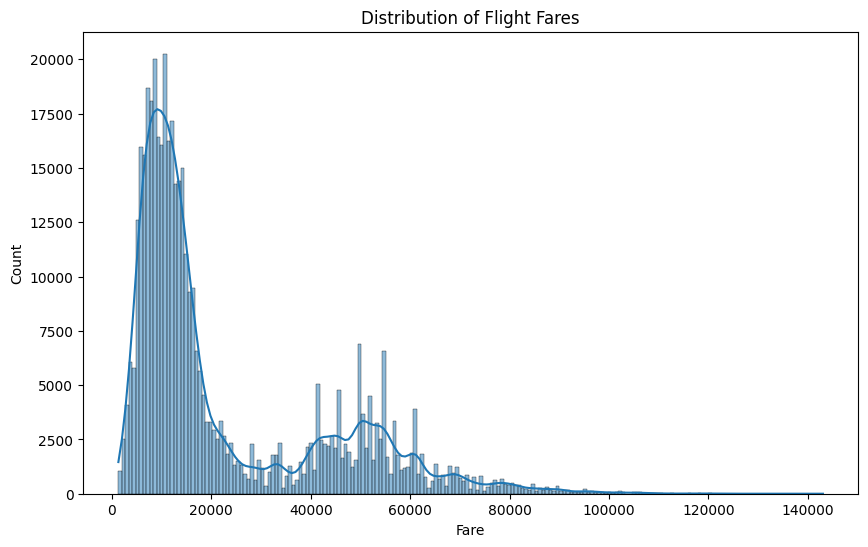

In [11]:
# Visualize the distribution of fares
plt.figure(figsize=(10, 6))
sns.histplot(df['Fare'], kde=True)
plt.title('Distribution of Flight Fares')
plt.xlabel('Fare')
plt.show()




### Step 4: Encode Categorical Variables
We label encode categorical columns like **Airline, Flight Code, Class, Source,** and **Destination**. Label encoding converts each category into a unique integer, making the data suitable for machine learning models.


In [12]:
# Encode categorical variables using Label Encoding
categorical_columns = ['Airline', 'Flight_code', 'Class', 'Source', 'Destination']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Impute missing values in 'Departure_hour' and 'Arrival_hour' using the median
df['Departure_hour'] = df['Departure_hour'].fillna(df['Departure_hour'].median())
df['Arrival_hour'] = df['Arrival_hour'].fillna(df['Arrival_hour'].median())

# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)


### Step 5: Feature Engineering
We engineer interaction features to capture relationships between variables. Additionally, we apply a log transformation to the target variable, `Fare`, to normalize the data and improve regression model performance.


In [13]:
# Feature Engineering: Interaction features
df['Departure_Duration'] = df['Departure_hour'] * df['Duration_in_hours']
df['Arrival_Duration'] = df['Arrival_hour'] * df['Duration_in_hours']

# Log Transform the Target Variable for Regression
df['Log_Fare'] = np.log1p(df['Fare'])


### Step 6: Prepare Data for Regression
We define the feature set and target variable for regression and split the data into training and testing sets for evaluation.


In [14]:
# Define Features and Target for Regression
X_reg = df.drop(['Fare', 'Log_Fare'], axis=1)
y_reg = df['Log_Fare']

# Train-Test Split for Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)


### Step 7: Regression Models (XGBoost, Random Forest, Gradient Boosting)
We train and evaluate regression models using XGBoost, Random Forest, and Gradient Boosting, and visualize their predictions.



XGBoost Regression Performance:
RMSE: 0.1628028728364296
R-squared (R²): 0.9551320723214448


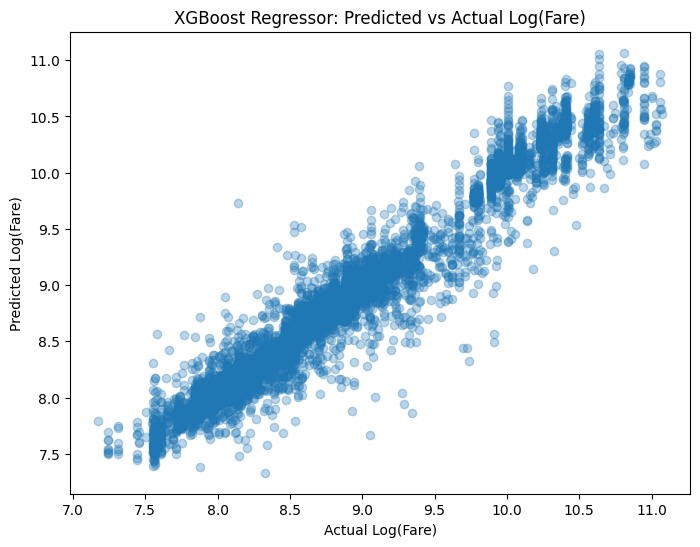


Random Forest Regression Performance:
RMSE: 0.19344851448494613
R-squared (R²): 0.9366505744810647


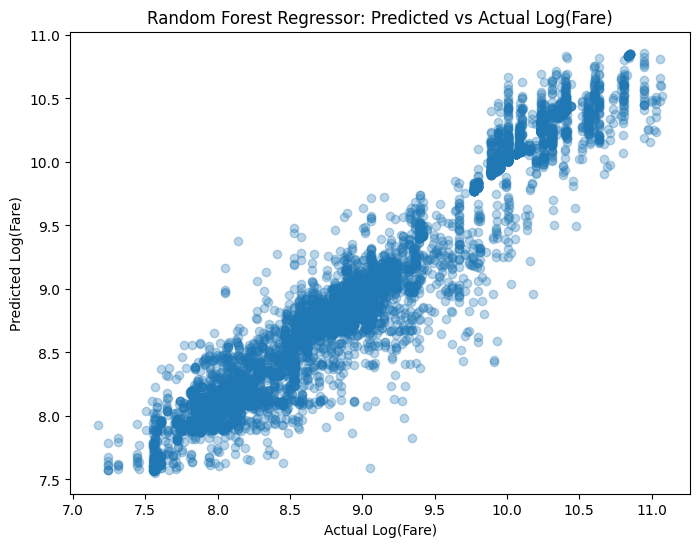


Gradient Boosting Regression Performance:
RMSE: 0.16423091446252105
R-squared (R²): 0.9543414931404968


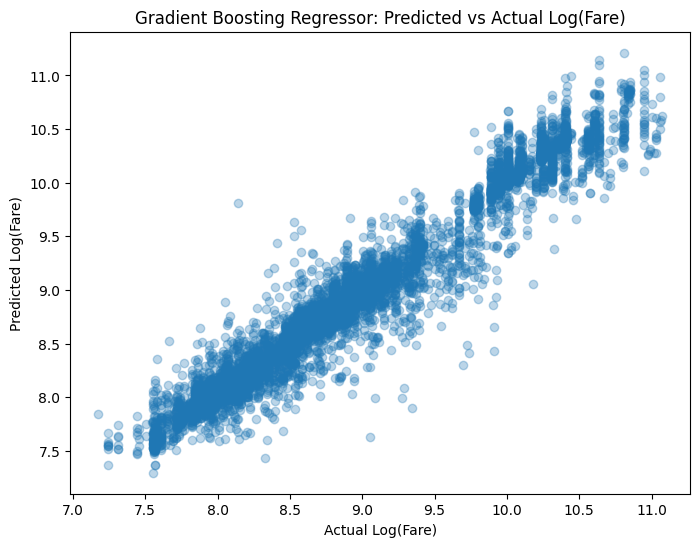

In [16]:
# Train and evaluate regression models
models_regression = {
    "XGBoost": XGBRegressor(n_estimators=400, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=400, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=400, max_depth=7, learning_rate=0.2, random_state=42)
}

for name, model in models_regression.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)
    print(f"\n{name} Regression Performance:")
    print(f"RMSE: {rmse}")
    print(f"R-squared (R²): {r2}")
    
    # Visualization of predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_reg, y_pred, alpha=0.3)
    plt.xlabel("Actual Log(Fare)")
    plt.ylabel("Predicted Log(Fare)")
    plt.title(f"{name} Regressor: Predicted vs Actual Log(Fare)")
    plt.show()


# Step 8: Classification Data Preparation
Define target categories (Low, Medium, High) for classification.



In [17]:
# Categorize 'Fare' into Low, Medium, and High categories
df['Fare_Category'] = pd.qcut(df['Fare'], q=3, labels=['Low', 'Medium', 'High'])
df['Fare_Category'] = LabelEncoder().fit_transform(df['Fare_Category'])

# Define Features and Target for classification
X_class = df.drop(['Fare', 'Fare_Category', 'Log_Fare'], axis=1)
y_class = df['Fare_Category']

# Split data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)


# Step 9: Classification Models (XGBoost, Random Forest, Gradient Boosting)
Train and evaluate classification models by calculating AUC scores.


In [18]:
# Train and evaluate classification models
models_classification = {
    "XGBoost": XGBClassifier(n_estimators=400, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=400, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=400, max_depth=7, learning_rate=0.2, random_state=42)
}

for name, model in models_classification.items():
    model.fit(X_train_class, y_train_class)
    y_pred_proba = model.predict_proba(X_test_class)
    auc = roc_auc_score(y_test_class, y_pred_proba, multi_class='ovo')
    print(f"\n{name} Classification AUC: {auc}")



XGBoost Classification AUC: 0.9882127679970013

Random Forest Classification AUC: 0.9754021166883295

Gradient Boosting Classification AUC: 0.9867664936234846


# Step 10: Feature Importance for XGBoost Classifier
Plot top feature importances.


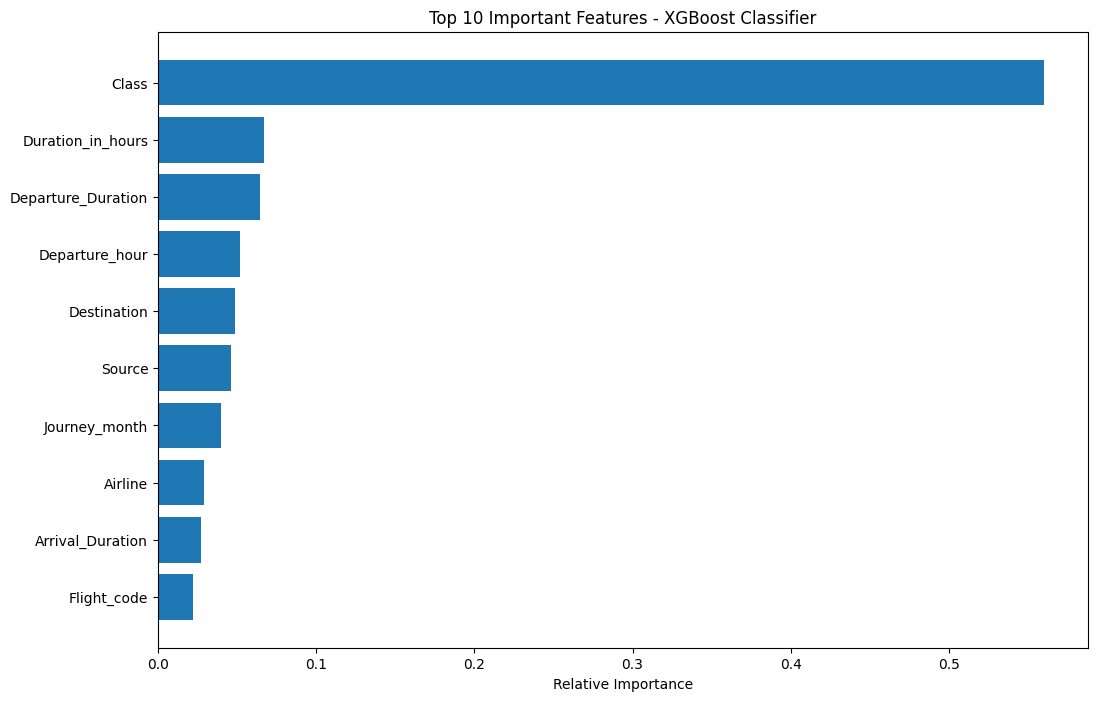

In [20]:
# Plot feature importances for XGBoost Classifier
plt.figure(figsize=(12, 8))
xgb_importances = models_classification["XGBoost"].feature_importances_
indices = np.argsort(xgb_importances)[-10:]  # Select top 10 important features

plt.barh(range(len(indices)), xgb_importances[indices], align='center')
plt.yticks(range(len(indices)), [X_class.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.title("Top 10 Important Features - XGBoost Classifier")
plt.show()
